# Outlier Detection

In [246]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns


In [247]:
df=pd.read_csv("data/Pokemon.csv")

In [248]:
df.isnull().sum()

#               0
Name            0
Type 1          0
Type 2        386
Total           0
HP              0
Attack          0
Defense         0
Sp. Atk         0
Sp. Def         0
Speed           0
Generation      0
Legendary       0
dtype: int64

In [249]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 800 entries, 0 to 799
Data columns (total 13 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   #           800 non-null    int64 
 1   Name        800 non-null    object
 2   Type 1      800 non-null    object
 3   Type 2      414 non-null    object
 4   Total       800 non-null    int64 
 5   HP          800 non-null    int64 
 6   Attack      800 non-null    int64 
 7   Defense     800 non-null    int64 
 8   Sp. Atk     800 non-null    int64 
 9   Sp. Def     800 non-null    int64 
 10  Speed       800 non-null    int64 
 11  Generation  800 non-null    int64 
 12  Legendary   800 non-null    bool  
dtypes: bool(1), int64(9), object(3)
memory usage: 75.9+ KB


## Encode to be able to input missing values

In [250]:
from sklearn.preprocessing import LabelEncoder


def encode_object_columns(df):
    obj_cols = df.select_dtypes(include=["object", "boolean"]).columns
    for col in obj_cols:
        le = LabelEncoder()
        df[col] = df[col].astype(str)
        df[col] = le.fit_transform(df[col])
    return df

df = encode_object_columns(df)

# Drop ID column
df.drop(columns=["#"])



,Name,Type 1,Type 2,Total,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed,Generation,Legendary
0,80,9,13,318,45,49,49,65,65,45,1,0
1,329,9,13,405,60,62,63,80,80,60,1,0
2,745,9,13,525,80,82,83,100,100,80,1,0
3,746,9,13,625,80,100,123,122,120,80,1,0
4,102,6,18,309,39,52,43,60,50,65,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...
795,160,15,4,600,50,100,150,100,150,50,6,1
796,161,15,4,700,50,160,110,160,110,110,6,1
797,314,14,8,600,80,110,60,150,130,70,6,1
798,315,14,1,680,80,160,60,170,130,80,6,1


## Secondly encode data to see correlation to target column 

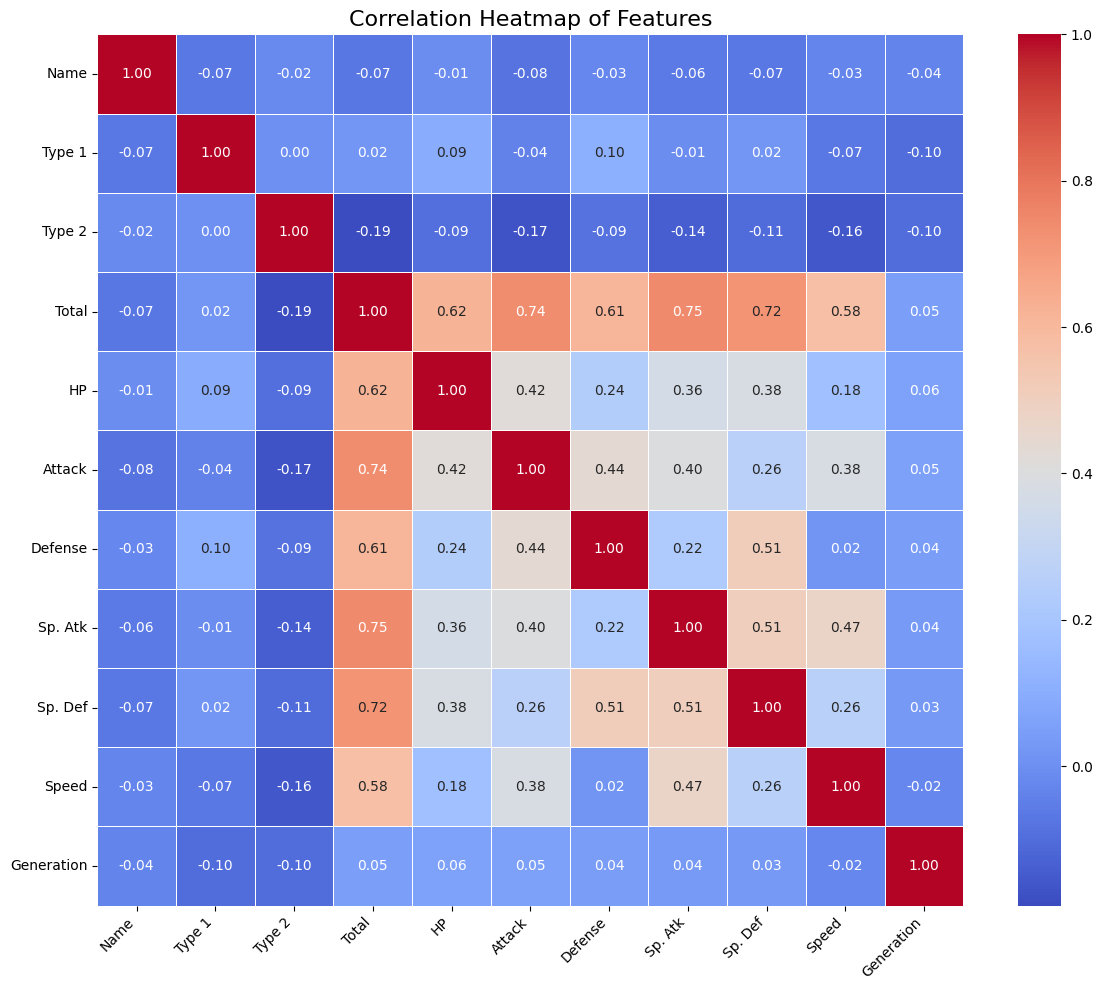

In [251]:
plt.figure(figsize=(12, 10))
numerical_cols = df.select_dtypes(include=np.number).columns
numerical_df = df[numerical_cols].drop(columns=['Legendary',"#"], errors='ignore')
corr_matrix = numerical_df.corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.title('Correlation Heatmap of Features', fontsize=16)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

In [252]:
from reparo import KNNImputer

imputer = KNNImputer(n_neighbors=7)
df['Type 2'] = imputer.fit_transform(df['Type 2'])

In [253]:
target_col ="Legendary"

corr_matrix = df.corr()['Legendary'].abs().sort_values(ascending=False)

print(corr_matrix)

Legendary     1.000000
Total         0.501758
Sp. Atk       0.448907
Sp. Def       0.363937
Attack        0.345408
Speed         0.326715
HP            0.273620
Defense       0.246377
#             0.153396
Type 2        0.087771
Generation    0.079794
Name          0.047575
Type 1        0.010162
Name: Legendary, dtype: float64


# Create dataset from 2 most correlated features

In [254]:
from sklearn.preprocessing import StandardScaler

x_cols = ['Total', 'Sp. Atk']
target_col = 'Legendary'

x = df[x_cols]
y = df[target_col]

#Use scaler because algorithms OneClassSVM, EllipticEnvelope are sensitive un unscalled data
scaler = StandardScaler()
x_scaled = scaler.fit_transform(x)
x_scaled_df = pd.DataFrame(x_scaled, columns=x_cols)

## Predictions

In [255]:
from sklearn.ensemble import IsolationForest
from sklearn.svm import OneClassSVM
from sklearn.covariance import EllipticEnvelope
from sklearn.neighbors import LocalOutlierFactor
contamination_value = 0.05

models = {
    "Isolation Forest": IsolationForest(random_state=42, contamination=contamination_value),
    "OneClassSVM": OneClassSVM(nu=contamination_value, kernel="rbf", gamma='auto'),
    "Elliptic Envelope": EllipticEnvelope(contamination=contamination_value, random_state=42),
    "Local Outlier Factor": LocalOutlierFactor(n_neighbors=20, contamination=contamination_value, novelty=False)
}

predictions = {}

for name, model in models.items():
    if name == "Local Outlier Factor":
        predictions[name] = model.fit_predict(x_scaled_df)
    else:
        model.fit(x_scaled_df)
        predictions[name] = model.predict(x_scaled_df)

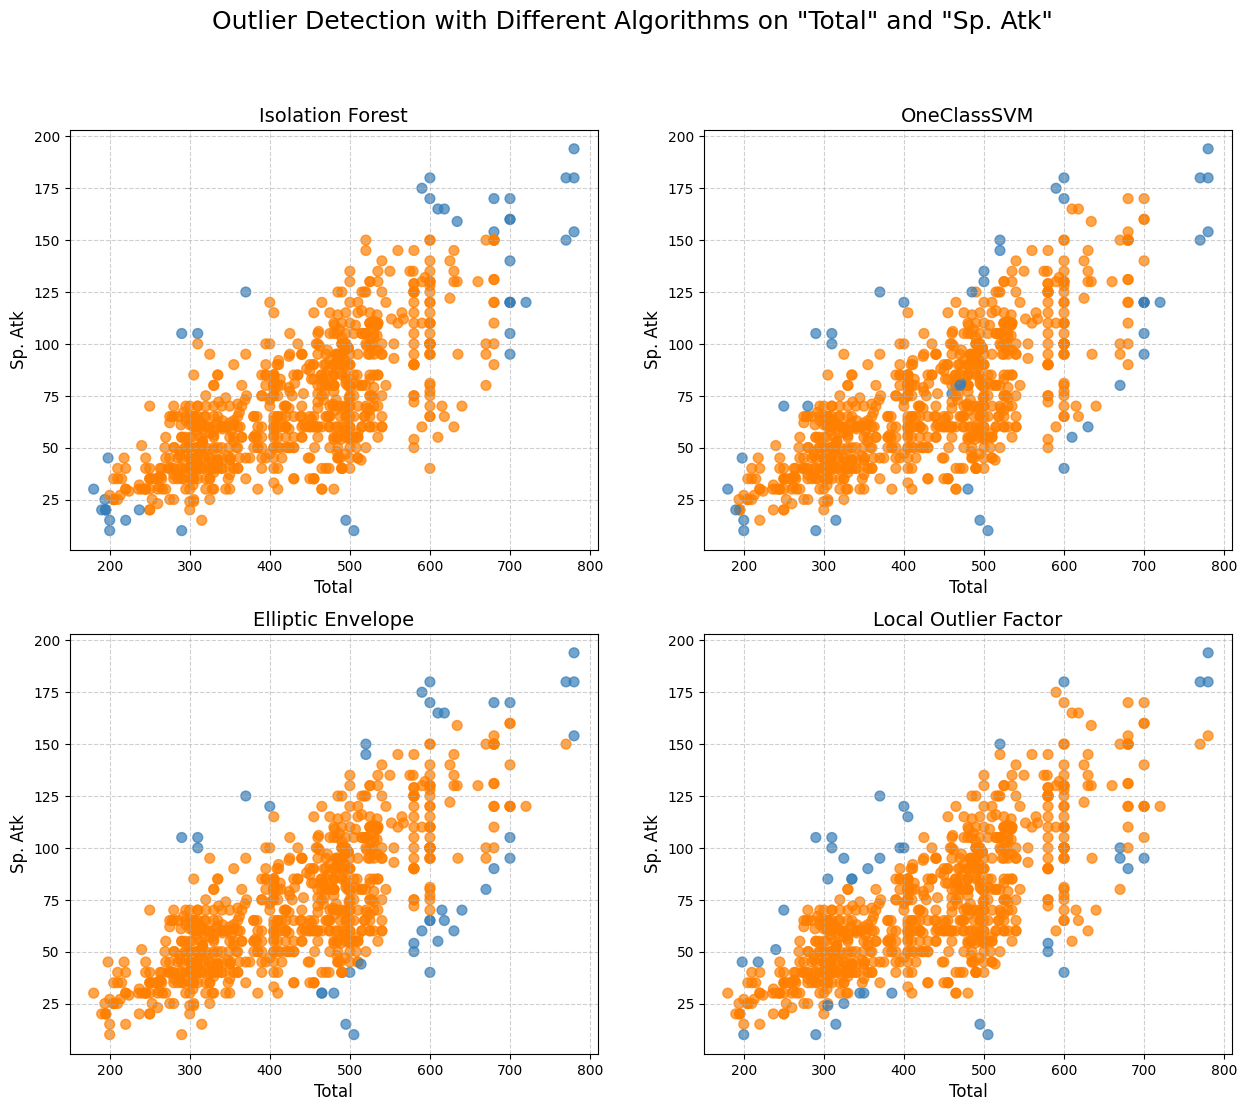

In [256]:
fig, axes = plt.subplots(2, 2, figsize=(15, 12))
axes = axes.flatten()
plt.suptitle('Outlier Detection with Different Algorithms on "Total" and "Sp. Atk"', fontsize=18)

for i, (name, preds) in enumerate(predictions.items()):
    ax = axes[i]
    colors = np.array(['#377EB8', '#FF7F00'])[((preds + 1) // 2).astype(int)]

    ax.scatter(x['Total'], x['Sp. Atk'], color=colors, s=50, alpha=0.7)
    ax.set_title(name, fontsize=14)
    ax.set_xlabel('Total', fontsize=12)
    ax.set_ylabel('Sp. Atk', fontsize=12)
    ax.grid(True, linestyle='--', alpha=0.6)

In plot I detected that most accurate is IsolationForest and the same good results has EllipticEnvelope.Local Outlier Factor and OneClassSVM provides good results but also are present some misunderstandings in their plots  

In [ ]:
import warnings
warnings.filterwarnings("ignore", message="X does not have valid feature names")
#This warning appears because in a for loop make predictions for all algorithms and each of them some specific points how work


# Prepare for whole dataset

numeric_cols_for_whole_dataset = df.columns.tolist()

if target_col in numeric_cols_for_whole_dataset:
    numeric_cols_for_whole_dataset.remove(target_col)

X_whole = df[numeric_cols_for_whole_dataset]
X_scaled = StandardScaler().fit_transform(X_whole)
X_df = pd.DataFrame(X_scaled, columns=X_whole.columns)

contamination_values = [0.01,0.02,0.03,0.04,0.05,0.08,0.1,0.2,0.4,0.5]

outlier_counts = {
    "Isolation Forest": [],
    "OneClassSVM": [],
    "Elliptic Envelope": [],
    "Local Outlier Factor": []
}


for cont in contamination_values:
    # Isolation Forest
    iso = IsolationForest(contamination=cont, random_state=42)
    n_iso = np.sum(iso.fit_predict(X_df) == -1)
    outlier_counts["Isolation Forest"].append(n_iso)

    # One-Class SVM
    svm = OneClassSVM(nu=cont, gamma='auto')
    svm.fit(X_df)
    n_svm = np.sum(svm.predict(X_df) == -1)
    outlier_counts["OneClassSVM"].append(n_svm)

    # Elliptic Envelope
    try:
        with warnings.catch_warnings():
            warnings.simplefilter("ignore")
            ee = EllipticEnvelope(contamination=cont, random_state=42)
            n_ee = np.sum(ee.fit(X_df).predict(X_df) == -1)
    except:
        n_ee = np.nan
    outlier_counts["Elliptic Envelope"].append(n_ee)

    # Local Outlier Factor
    lof = LocalOutlierFactor(n_neighbors=20, novelty=True)
    lof.fit(X_df)
    scores = lof.decision_function(X_df)
    thresh = np.percentile(scores, cont * 100)
    n_lof = np.sum(scores <= thresh)
    outlier_counts["Local Outlier Factor"].append(n_lof)



## Plot results for whole dataset

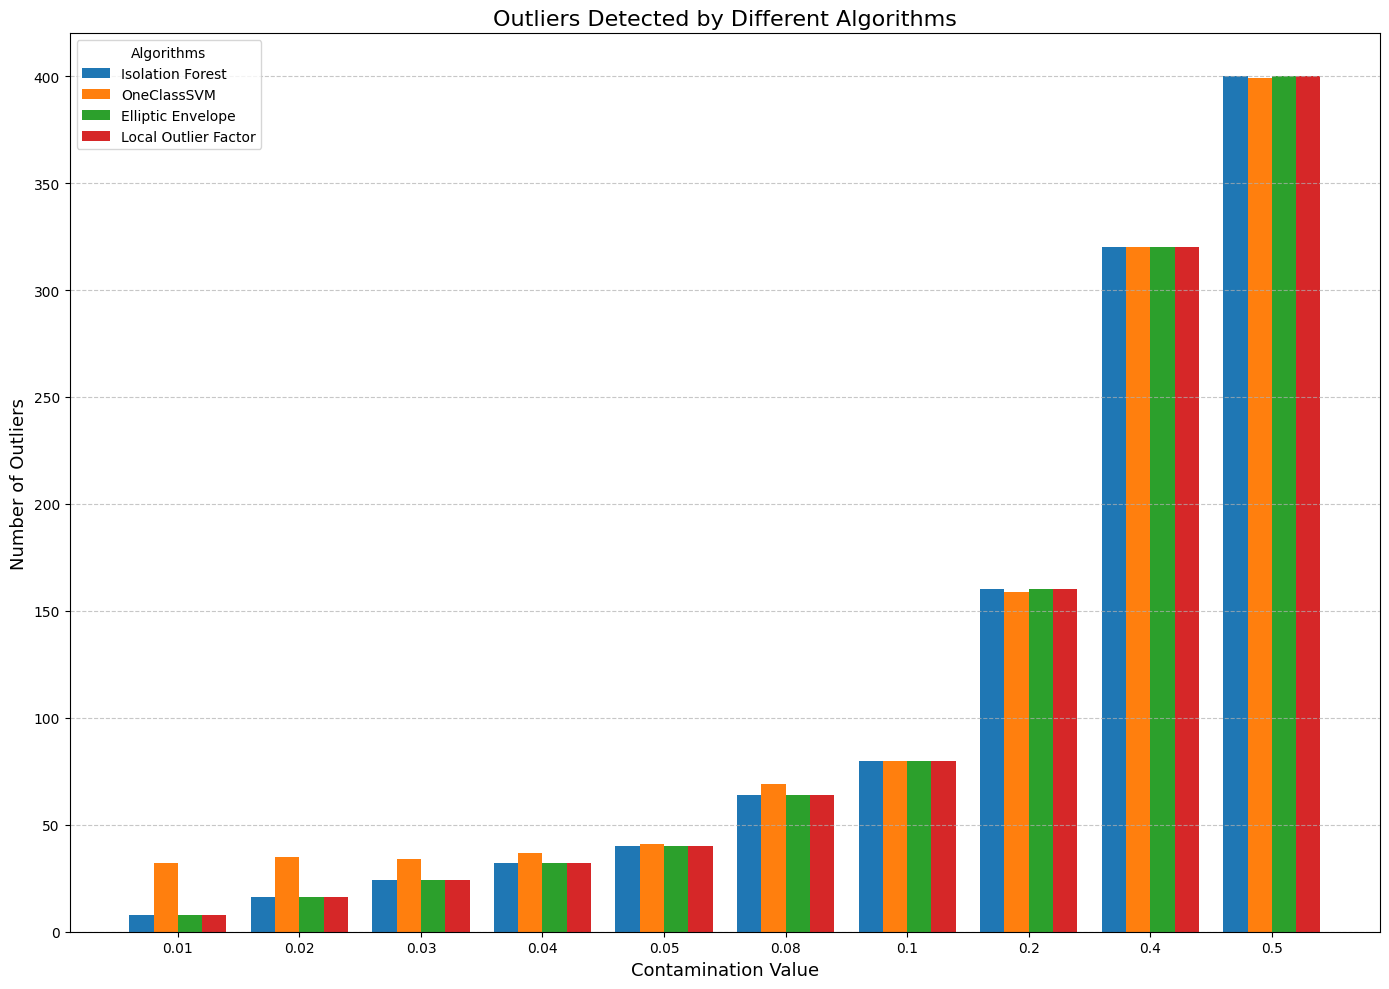

In [ ]:
results_df = pd.DataFrame(outlier_counts, index=contamination_values)
bar_width = 0.2
x = np.arange(len(results_df))

plt.figure(figsize=(14, 10))

for i, col in enumerate(results_df.columns):
    plt.bar(x + i * bar_width, results_df[col], width=bar_width, label=col)

plt.xticks(x + bar_width * 1.5, contamination_values)
plt.xlabel("Contamination Value", fontsize=13)
plt.ylabel("Number of Outliers", fontsize=13)
plt.title("Outliers Detected by Different Algorithms", fontsize=16)
plt.legend(title="Algorithms")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

Use OneClassSVM for small contamination values < 0.5 when contamination is higher in my case it do not depends by used algorithm

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import r2_score


X = df.drop(columns=[target_col])
y = df[target_col]

from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_scaled_df = pd.DataFrame(X_scaled, columns=X.columns)

X_train, X_test, y_train, y_test = train_test_split(X_scaled_df, y, test_size=0.2, random_state=42)


# Remove outliers with default algorithms settings

In [ ]:


def remove_outliers(model_name, X, y):
    if model_name == "Isolation Forest":
        model = IsolationForest()
        preds = model.fit_predict(X)
    elif model_name == "OneClassSVM":
        model = OneClassSVM(gamma='auto')
        preds = model.fit(X).predict(X)
    elif model_name == "Elliptic Envelope":
        model = EllipticEnvelope()
        preds = model.fit(X).predict(X)
    elif model_name == "Local Outlier Factor":
        model = LocalOutlierFactor()
        preds = model.fit_predict(X)
    else:
        raise ValueError("Unknown model")

    # Save only inliers
    mask = preds == 1
    return X[mask], y[mask]


## Model Training

In [ ]:

results = []

regressors = {
    "Linear Regression": LinearRegression(),
    "KNN Regressor": KNeighborsRegressor()
}

outlier_algos = ["None", "Isolation Forest", "OneClassSVM", "Elliptic Envelope", "Local Outlier Factor"]

for outlier_algo in outlier_algos:
    if outlier_algo == "None":
        X_train_clean, y_train_clean = X_train, y_train
    else:
        try:
            with warnings.catch_warnings():
                warnings.simplefilter("ignore")
                X_train_clean, y_train_clean = remove_outliers(outlier_algo, X_train, y_train)
        except Exception as e:
            print(f"Skipping {outlier_algo} due to error: {e}")
            continue

    for model_name, model in regressors.items():
        model.fit(X_train_clean, y_train_clean)
        y_pred = model.predict(X_test)
        score = r2_score(y_test, y_pred)
        results.append({
            "Outlier Detection": outlier_algo,
            "Regressor": model_name,
            "R2 Score": round(score, 4)
        })


## Evaluate combinations with outliers and without them

In [262]:
results_df = pd.DataFrame(results)
print(results_df.pivot(index="Outlier Detection", columns="Regressor", values="R2 Score"))


Regressor             KNN Regressor  Linear Regression
Outlier Detection                                     
Elliptic Envelope            0.5008             0.2184
Isolation Forest             0.5477             0.2525
Local Outlier Factor         0.4581             0.2233
None                         0.4795             0.2422
OneClassSVM                  0.4325             0.2113


### The results show that the KNN Regressor generally outperforms Linear Regression across all outlier detection methods. Isolation Forest and Elliptic Envelope got highest R2 scores for KNN, indicating an efficient outlier removal. 

### Linear Regression performs best without outlier removal, this means it is less sensitive to outliers